#Using Intel Image classification dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split
import pathlib

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch.optim import Adam
import torchvision
from torchvision.utils import make_grid

In [3]:
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = 'https://drive.google.com/file/d/14OWM5iYu9l_otRs-_hj2SLIq5GyvrfrV/view?usp=drive_link'

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/Intel Image classification dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Intel Image classification dataset/train_data/mountain/7539.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7551.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7560.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7565.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7578.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7581.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7586.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7647.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7652.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7654.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/7662.jpg  
  inflating: Intel Image classification dataset/train_data/mountain/767.jpg  
  

In [6]:
train_path = '/content/Intel Image classification dataset/train_data'
test_path = '/content/Intel Image classification dataset/test_data'

In [7]:
import os
train_count = sum(len(files) for _, _, files in os.walk(train_path))
test_count = sum(len(files) for _, _, files in os.walk(test_path))
print(train_count)
print(test_count)

14034
3000


In [8]:
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transform),batch_size=64,shuffle=True)

test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),batch_size=32,shuffle=True)

In [9]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [10]:
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [16]:
class Model(nn.Module):
  def __init__(self,num_classes=6):
    super(Model,self).__init__()

    #input shape = (256,3,150,150)
    self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
    #shape = (256,12,150,150)
    self.bn1 = nn.BatchNorm2d(num_features=12)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)
    #reduce the image size by a factor of 2
    #shape = (256,12,75,75)

    self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
    #shape = (256,20,75,75)
    self.relu2 = nn.ReLU()
    #shape = (256,20,75,72)

    self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
    #shape = (256,32,75,75)
    self.bn3 = nn.BatchNorm2d(num_features=32)
    #shape = (256,32,75,75)
    self.relu3 = nn.ReLU()
    #shape = (256,32,75,75)

    self.fc = nn.Linear(in_features=32*75*75,out_features=num_classes)

    #Feed Forward function
  def forward(self,input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.relu(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.relu2(output)

    output = self.conv3(output)
    output = self.bn3(output)
    output = self.relu3(output)

    #Output will be in matrix form of dimensions - (256,32,75,75)

    output = output.view(-1,32*75*75)
    output = self.fc(output)

    return output

In [17]:
model = Model(num_classes=6)

In [18]:
optimizer = Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [19]:
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):

    # Training on the training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / len(train_loader)
    train_loss = train_loss / len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy))

Epoch: 0 Train Loss: 5.460732253573157 Train Accuracy: 37.54545454545455
Epoch: 1 Train Loss: 2.035753328420899 Train Accuracy: 46.47727272727273
Epoch: 2 Train Loss: 0.8758908224376765 Train Accuracy: 52.64545454545455
Epoch: 3 Train Loss: 0.625438294288787 Train Accuracy: 54.57727272727273
Epoch: 4 Train Loss: 0.3559415062550794 Train Accuracy: 57.3
Epoch: 5 Train Loss: 0.252039136170325 Train Accuracy: 59.263636363636365
Epoch: 6 Train Loss: 0.17730704257264734 Train Accuracy: 60.49090909090909
Epoch: 7 Train Loss: 0.18367593268101864 Train Accuracy: 60.43636363636364
Epoch: 8 Train Loss: 0.13752732822163538 Train Accuracy: 61.43181818181818
Epoch: 9 Train Loss: 0.12860864018174736 Train Accuracy: 61.33181818181818


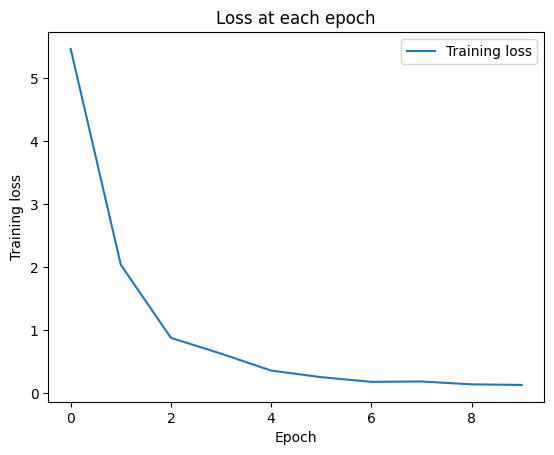

In [20]:
plt.plot(train_losses, label="Training loss")
plt.title("Loss at each epoch")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.legend()
plt.show()

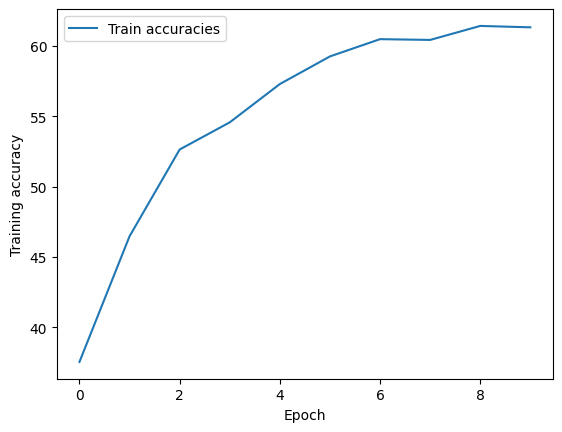

In [21]:
plt.plot(train_accuracies,label="Train accuracies")
plt.xlabel("Epoch")
plt.ylabel("Training accuracy")
plt.legend()
plt.show()

In [24]:
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Calculate the overall test loss and accuracy
final_test_loss = test_loss / len(test_loader)
final_test_accuracy = correct_test / total_test

print(f"Test loss - {final_test_loss} Test Accuracy - {final_test_accuracy}")


Test loss - 1.1878716855290088 Test Accuracy - 0.7553333333333333


In [28]:
torch.save(model.state_dict(), 'Intel image classifier.pt')

In [1]:
import pickle

In [2]:
new_file = open('model.pckl','wb')